# Vectorization 101

In [2]:
import numpy as np

`vectorization` refers to a programming style where you use numpy's ability to operate on whole arrays at once, instead of using explicit for-loops.

## All-array operations

In [3]:
a = np.array([1., 2., 3., 4., 5., 6., 7., 8.])

### First of all, it's convenient

In [4]:
# "standardize" an array

(a - a.mean()) / a.std()

array([-1.52752523, -1.09108945, -0.65465367, -0.21821789,  0.21821789,
        0.65465367,  1.09108945,  1.52752523])

Compare to

In [8]:
lst = [1., 2., 3., 4., 5., 6., 7., 8.]

from math import sqrt

a_mean = sum(lst) / len(lst)
a_std = sqrt(sum((x - a_mean)**2 for x in lst) / len(lst))

[(x - a_mean) / a_std for x in lst]

[-1.5275252316519468,
 -1.091089451179962,
 -0.6546536707079772,
 -0.2182178902359924,
 0.2182178902359924,
 0.6546536707079772,
 1.091089451179962,
 1.5275252316519468]

### Second, it's faster.

One more (artificial) example:

In [2]:
a = np.array([1., 2., 3., 4., 5., 6., 7., 8.])
b = a**2  + np.sin(a)
b

array([  1.84147098,   4.90929743,   9.14112001,  15.2431975 ,
        24.04107573,  35.7205845 ,  49.6569866 ,  64.98935825])

The following is an exact equivalent:

In [17]:
from math import sin

b = np.zeros(30)
for i in range(len(a)):
    b[i] = a[i]**2 + sin(a[i])

Why bothering: let's time it.

In [18]:
%timeit b = a**2 + np.sin(a)

2.83 µs ± 90.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
%%timeit
for i in range(len(a)):
    b[i] = a[i]**2 + sin(a[i])

8.35 µs ± 28 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
8.35 / 2.83

2.9505300353356887

On my laptop the vectorized form is faster by a factor of about 3. The difference increases as your arrays get larger.

Notice how numpy's `sin` function operates on the whole array elementwise. This is a typical behavior of the universal functions, `ufuncs`.  

### One more example: let's threshold an array.

In [23]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
a[a <= 4] = -101
a

array([-101, -101, -101, -101, -101,    5,    6,    7,    8,    9])

In [27]:
(2 < a) & (a <= 7)

array([False, False, False, False, False,  True,  True,  True, False, False], dtype=bool)

# *Cochleoid*

In polar coordinates
$$
r = \frac{\sin{\phi}}{\phi}
$$

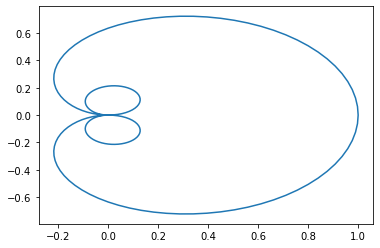

In [3]:
phi = np.linspace(-2*np.pi, 2*np.pi, 201)

phi = phi[phi != 0]
r = np.sin(phi) / phi

x = r * np.cos(phi)
y = r * np.sin(phi)

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()

# Internals of an np.array

In [4]:
a = np.arange(8).reshape((2, 4))
a

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [42]:
a.data

In [43]:
a.dtype

dtype('int64')

In [44]:
a.ndim

2

In [45]:
a.shape

(2, 4)

In [46]:
a.strides

(32, 8)

In [6]:
a.view(float)

array([[0.0e+000, 4.9e-324, 9.9e-324, 1.5e-323],
       [2.0e-323, 2.5e-323, 3.0e-323, 3.5e-323]])

In [7]:
a.astype(float)

array([[0., 1., 2., 3.],
       [4., 5., 6., 7.]])

# The power of slicing

From a student's email:

> A general issue of speed for the overall program. A single run with sufficient data points is taking about 2-3 weeks.


Neighborhood averages of a two-dim array.


In [8]:
# set up an array

m, n = 4, 4
a = np.arange(m*n, dtype=np.float).reshape((m, n))
a

array([[  0.,   1.,   2.,   3.],
       [  4.,   5.,   6.,   7.],
       [  8.,   9.,  10.,  11.],
       [ 12.,  13.,  14.,  15.]])

First, a non-vectorized code:

In [9]:
b = np.zeros((m-1, n-1))
for i in range(m-1):
    for j in range(n-1):
        b[i, j] = a[i, j] + a[i+1, j] + a[i, j+1] + a[i+1, j+1]
b

array([[ 10.,  14.,  18.],
       [ 26.,  30.,  34.],
       [ 42.,  46.,  50.]])

Now use the fact that for each axis of the array,
- indexing starts from 0,
- negative indices mean counting from the end, and
- indexing can be done by `slices`, which are half-open: `a[start:stop]` is a sub-array of `a`, which contains `a[start]`, `a[start+1]` and so on, up to and *excluding* `a[stop]`.

This way, for a 1D array `a`, `a[0]` is the first element, `a[-1]` is the last element, and `a[1:3]` is `[a[1], a[2]]`.

Also notice that if `start` is zero, it can be omitted, so that `a[0:3]` and `a[:3]` are equivalent. Ditto for the maximum value of `stop`.

Armed with this, here's a vectorized form of the double loop above:

In [10]:
b_vect = a[:-1, :-1] + a[1:, :-1] + a[:-1, 1:] + a[1:, 1:]

In [11]:
b_vect == b

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]], dtype=bool)

In [47]:
m, n = 50, 50
a = np.arange(m*n, dtype=float).reshape((m, n))

In [48]:
%timeit a[:-1, :-1] + a[1:, :-1] + a[:-1, 1:] + a[1:, 1:]

23.6 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
%%timeit

for i in range(m-1):
    for j in range(n-1):
        a[i, j] + a[i+1, j] + a[i, j+1] + a[i+1, j+1]

2.63 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Conway's game of life

Cells live on a square grid. Each cell can be in either of two states: alive or dead. Cells interact with nearest neighbors.

At each *tick*, 

- Any live cell with `<2` neighbors dies, as if of underpopulation.
- Any live cell with `>3` neighbors dies, as if of overpopulation.
- Any dead cell with `=3` neighbors becomes a live cell, as if by reproduction.

From a cell-centric view to a whole-array formulation: for each cell, consider the sum of nine fields.
- If the sum `= 3`, central cenral cell's state is life.
- If the sum `= 4`, the state of the central cell does not change
- Otherwise, it dies.

In [58]:
def step(X):
    """Given a game board ``X``, make a time step and return the result.
    
    NB: In this implementation the game field is finite.

    """
    num_neighb = (X[:-2, :-2]  + X[1:-1, :-2]  + X[2:, :-2] +
                  X[:-2, 1:-1] + X[1:-1, 1:-1] + X[2:, 1:-1] +
                  X[:-2, 2:]   + X[1:-1, 2:]   + X[2:, 2:])
    
    X[1:-1, 1:-1][num_neighb == 3] = 1
    X[1:-1, 1:-1][(num_neighb != 4) & (num_neighb != 3)] = 0
    return X

# https://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/

# Broadcasting

Overheard on the numpy-discussion mailing list at some point:

OP:

> I personally think that silent Broadcasting is not a good thing. I had recently a lot of trouble with row and column vectors which got bradcastet toghether ...

Chuck Harris (numpy RM):

> It's how numpy works. 

In [10]:
a = np.arange(8).reshape((2, 4))
a

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [11]:
b = np.arange(4, 0, -1)
b

array([4, 3, 2, 1])

In [12]:
a - b

array([[-4, -2,  0,  2],
       [ 0,  2,  4,  6]])

The formal rule: Given two arrays, `S` and `P`, with shapes

$$
    \begin{aligned}
        \mathrm{S.shape} &= (\cdots, s_3, s_2, s_1) \\
        \mathrm{P.shape} &= (\cdots, p_3, p_2, p_1)
    \end{aligned}
$$

broadcasting works from the right backwards:

* If the number of dimensions of `S` and `P` is different, left-pad the smaller shape with ones.

* If $s_j = 1$ and $p_j \neq 1$, the corresponding axis of the `S` array is treated as if it were expanded to have $p_j$ elements.

* If $s_j \neq p_j \neq 1$, it's an error.

In [13]:
a.shape

(2, 4)

In [14]:
b.shape

(4,)

## Cauchy matrix

Given two vectors, $\vec{u}$ and $\vec{v}$, 

$$
C_{jk} = \frac{1}{u_j - v_k}
$$

In [77]:
u = np.arange(4)
v = u + 0.5

C = 1 / (u[:, None] - v[None, :])
    
np.set_printoptions(precision=3)
C

array([[-2.   , -0.667, -0.4  , -0.286],
       [ 2.   , -2.   , -0.667, -0.4  ],
       [ 0.667,  2.   , -2.   , -0.667],
       [ 0.4  ,  0.667,  2.   , -2.   ]])

In [78]:
# Equivalently,

1. / np.subtract.outer(u, v)

array([[-2.   , -0.667, -0.4  , -0.286],
       [ 2.   , -2.   , -0.667, -0.4  ],
       [ 0.667,  2.   , -2.   , -0.667],
       [ 0.4  ,  0.667,  2.   , -2.   ]])

## Stack your vectors (to N-D and beyond)

Things get more interesting when dealing with multidimensional arrays. 

Suppose we have a collection of vectors on a two-dimensional plane, and we represent them as two-element numpy arrays:

In [12]:
x1 = np.array([1., 1.])
x2 = np.array([4., -3.])
x3 = np.array([8., 0.])

Note that in numpy-speak, these are *one-dimensional arrays*  

In [13]:
x1.ndim

1

of shape (2,)

In [14]:
x1.shape

(2,)

Suppose that we want to calculate lengths of these vectors. For a single vector it's easy:

In [15]:
def norm(vect):
    """Compute an absolute value of a 2-d vector, represented as a 1-d numpy array."""
    return np.sqrt(vect[0]**2 + vect[1]**2)

Now it's also easy to loop over the vectors,

In [16]:
[norm(v) for v in (x1, x2, x3)]

[1.4142135623730951, 5.0, 8.0]

... but there is a better, vectorized way.

First, we stack our vectors together into a 3-by-2 array (or produce this array in a first place.)

In [17]:
x = np.vstack([x1, x2, x3])
x

array([[ 1.,  1.],
       [ 4., -3.],
       [ 8.,  0.]])

In [18]:
x.shape

(3, 2)

OK, squaring is an elementwise operation:

In [19]:
x**2

array([[  1.,   1.],
       [ 16.,   9.],
       [ 64.,   0.]])

Now to imitate the `norm` function above, we need to sum the elements in each row of `x**2` --- in the numpy-speak, it's a sum along the second axis:

In [21]:
np.sum(x**2, axis=1)

array([  2.,  25.,  64.])

Collecting this all together:

In [22]:
def norm_vect(xx):
    """Given a stack of d-dimensional vectors, compute their lengths.

    Parameters
    ----------
    xx : array_like, shape (m, d)
        Each row of `xx` represents a vector in d-dimensional space.

    Returns
    -------
    lengths : array_like, shape (d,)
        Euclidean lengths of the vectors
    """
    xx = np.asarray(xx)
    assert xx.ndim == 2   # safeguard
    nrm = np.sum(xx**2, axis=1)
    return np.sqrt(nrm)

In [23]:
norm_vect(x)

array([ 1.41421356,  5.        ,  8.        ])

# Numpy submodules

* `numpy.linalg`
* `numpy.random`

# Further reading

Numpy docs http://docs.scipy.org/doc/numpy/reference/index.html

Nicolas Rougier, *From Python to Numpy*, https://www.labri.fr/perso/nrougier/from-python-to-numpy/
    
Jake Vanderplas' *Numpy Intro*
http://nbviewer.ipython.org/github/jakevdp/2013_fall_ASTR599/blob/master/notebooks/05_NumpyIntro.ipynb

and *Efficient Numpy* http://nbviewer.ipython.org/github/jakevdp/2013_fall_ASTR599/blob/master/notebooks/11_EfficientNumpy.ipynb

or *Loosing your loops*
https://speakerdeck.com/jakevdp/losing-your-loops-fast-numerical-computing-with-numpy-pycon-2015

Pauli Virtanen, *Advanced Numpy* (Scipy lecture notes)
https://scipy-lectures.github.io/

Nicolas Rougier, *100 Numpy exercises*
https://github.com/rougier/numpy-100/